In [210]:
import sklearn
from sklearn.datasets import load_boston, load_diabetes
import tensorflow.compat.v2 as tf
import tensorflow.keras as keras
import sys
import matplotlib.pyplot as plt
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import List, Tuple
from num2words import num2words
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

sys.path.insert(0,' ../')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [46]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

## Load data

In [2]:


mnist = MNIST('../data')
x_train, y_train = mnist.load_training() #60,000 samples
x_test, y_test = mnist.load_testing()    #10,000 samples

In [3]:
x_train_img = [np.asarray(x_train).astype(np.float32)[i].reshape(28,28,1) for i in range(3)]


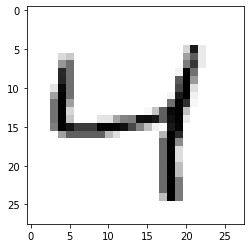

In [4]:
plt.imshow(x_train_img[2], cmap='Greys')

In [5]:
x_train = np.asarray(x_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.int32)
x_test =  np.asarray(x_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.int32)

# Primitive functions


### Sin

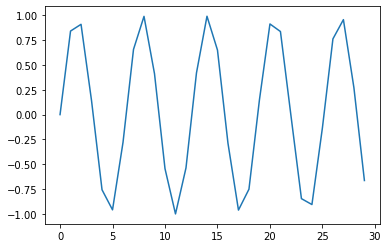

In [6]:
plt.plot(np.sin(np.arange(0,30)))

### Cosin

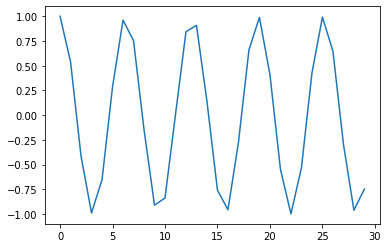

In [7]:
plt.plot(np.cos(np.arange(0,30)))

#### sqrt

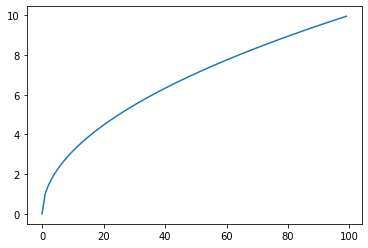

In [8]:
plt.plot(np.sqrt(np.arange(0,100)))

### log

<ipython-input-9-b3cb4314f8db>:1: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.arange(0,100)))


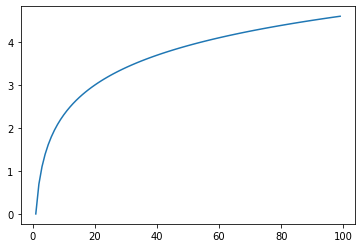

In [9]:
plt.plot(np.log(np.arange(0,100)))

In [100]:
t = np.array([1,2,3,4,5,6])

In [101]:
ids = np.arange(len(t))//4

In [102]:
ids

array([0, 0, 0, 0, 1, 1])

In [109]:
for i in range(0,len(t),4):
    print(t[i:i+4])

[1 2 3 4]
[5 6]


In [960]:
class MathFunctions():
    def __init__(self,weight):
        """weight is the parameter applied to all functions"""
        self.weight = weight

    def mf_sum(self, input_data):
       return  self.__x_number_sum(input_data)


    def mf_running_avg(self, input_data):
       return  self.__x_number_average(input_data)
    
    def mf_discrete_avg(self, input_data):

        ids = np.arange(len(input_data))//self.weight
        return np.bincount(ids,input_data)/np.bincount(ids)
    
    def mf_max_pool(self, input_data):
        new_max = []
        if type(input_data) == list:
            input_data = np.array(input_data)
            
        for i in range(0,len(input_data),self.weight):
            new_max.append(np.max(input_data[i:i+self.weight]))
        
        return new_max
    
    def mf_convolve(self, input_data):
        kernel = np.ones(self.weight)
        kernel = kernel*self.weight
        return np.convolve(input_data,kernel, 'valid')
        
        
    
    def mf_pow(self, input_data):
        return  np.power(input_data, self.weight)
    
    def mf_linear_transform(self, input_data):
        return input_data*self.weight + self.weight
    

    def __x_number_average(self, input_data):
        if type(input_data) == list:
            input_data = np.array(input_data)

        weight = self.weight
        if len(input_data) <= weight:
            return np.mean(input_data)

        len_ = len(input_data)
        new_data = []
        previous_row = 0
        for i in range(weight, len_+1):
            new_data.extend(
                [
                    np.mean(
                        input_data[previous_row: i]
                        )
                    ]
                )
            previous_row+=1
        return np.array(new_data)

    def __x_number_sum(self, input_data):
        if type(input_data) == list:
            input_data = np.array(input_data)

        weight = self.weight
        if len(input_data) <= weight:
            return np.sum(input_data)

        len_ = len(input_data)
        new_data = []
        previous_row = 0
        for i in range(weight, len_+1):
            new_data.extend([np.sum(input_data[previous_row: i])])
            previous_row += i
        return np.array(new_data)

        
        

    

In [961]:
custom_math_functions= MathFunctions(4)

In [962]:
assert custom_math_functions.mf_running_avg([10,10,20,20,10]).all() == np.array([15,15]).all()
assert custom_math_functions.mf_sum([10,10]) == [20]
assert custom_math_functions.mf_pow([10]) == [10000]

In [963]:
custom_math_functions.mf_discrete_avg([10,10,20,20,10]) 

array([15., 10.])

In [964]:
custom_math_functions.mf_max_pool([1,2,3,4,3,2,4])

[4, 4]

In [965]:
custom_math_functions.mf_sum([10,10,10,10,10,10])  # no overlap in the numbers

array([40, 10,  0])

In [966]:
custom_math_functions.mf_pow([10,10,10,10,10,10])  # no overlap in the numbers

array([10000, 10000, 10000, 10000, 10000, 10000])

In [970]:
len([10,2,3,4,34324,24,234,342,342,43,43])

11

In [971]:
len(custom_math_functions.mf_convolve([10,2,3,4,34324,24,234,342,342,43,43]))

8

# Define a non NN model

In [1019]:
class RandomModelArchitecture():
    
    def __init__(self, n_pixel_to_process, primitive_functions, math_function_class):
        self.math_function_class = math_function_class
        self.primitive_functions = primitive_functions
        self.n_pixel_to_process = n_pixel_to_process
#         self.random_weight = random_weight
        
    def set_rmse(self, rmse):
        self.rmse = rmse
        
    def set_loss(self,loss):
        self.loss = loss

        
    def get_random_architecture(self, input_image):
        """
        Return a list of strings corresponds to a model architecture for the given 
        """
        model_architecture = []
        while len(input_image) !=0:

            #pick the number to apply
            function_n = np.random.randint(len(self.primitive_functions))
            math_function_str = self.primitive_functions[function_n]
            if 'mf' in math_function_str:
                function_module = getattr(self.math_function_class, math_function_str)
            else:
                function_module = getattr(numpy, math_function_str)
            # Transform the image with the corresponding primitive function choosen
            input_image = function_module(input_image)

            model_architecture.append(math_function_str)
            # housekeeping in case our primitive functions go wonky
            input_image = np.nan_to_num(input_image)
            try:
                input_image[input_image == -np.inf] = 0
            except Exception as e:
                print(e)
                print(input_image)
            if  type(input_image) == numpy.float64 or type(input_image) == numpy.float32:
                break
            elif len(input_image) <= self.n_pixel_to_process: #Largest consolidation function
                break
        self.model_architecture = model_architecture


    def get_prediction_from_architecture(self, input_image):
        
        n_functions = len(self.model_architecture)
        for idx, math_function_str in enumerate(self.model_architecture):

            if  n_functions == idx+1: #Largest consolidation function

                # For now, just take the  mean of the last elements
                final_prediction = np.mean(input_image) 
                if np.isinf(final_prediction):
                    final_prediction = 0
                return final_prediction

            if 'mf' in math_function_str:
                function_module = getattr(self.math_function_class, math_function_str)
            else:
                function_module = getattr(numpy, math_function_str)

            # Transform the image with the corresponding primitive function choosen
            input_image = function_module(input_image)
            # housekeeping in case our primitive functions go wonky
            input_image = np.nan_to_num(input_image)
            input_image[input_image == -np.inf] = 0

    def agument_existing_architecture_list(self, input_image, augment_percent=0.80):
        """,
        For our genetic algorithm, given a list of architectures, keep the first half and randomly generate the second half
        """
        n_functions_in_architecture = len(self.model_architecture)


        if type(architecture_list) == list:
            self.model_architecture = np.array(self.model_architecture)
            
        n_functions_to_keep = int(augment_percent*n_functions_in_architecture)
        new_architecture_list = list(self.model_architecture[:n_functions_to_keep])

        for math_function_str in new_architecture_list:
            if 'mf' in math_function_str:
                function_module = getattr(self.math_function_class, math_function_str)
            else:
                function_module = getattr(numpy, math_function_str)

            # Transform the image with the corresponding primitive function choosen
            input_image = function_module(input_image)
            # housekeeping in case our primitive functions go wonky
            input_image = np.nan_to_num(input_image)
            input_image[input_image == -np.inf] = 0

        # Now, randomly generate the second half of the arhictecture
        while len(input_image) !=0:

            #pick the number to apply
            function_n = np.random.randint(len(self.primitive_functions))
            math_function_str = self.primitive_functions[function_n]
            if 'mf' in math_function_str:
                function_module = getattr(self.math_function_class, math_function_str)
            else:
                function_module = getattr(numpy, math_function_str)
            # Transform the image with the corresponding primitive function choosen
            input_image = function_module(input_image)

            new_architecture_list.append(math_function_str)
            # housekeeping in case our primitive functions go wonky
            input_image = np.nan_to_num(input_image)
            try:
                input_image[input_image == -np.inf] = 0
            except Exception as e:
                print(e)
                print(input_image)
                
            if  type(input_image) == numpy.float64 or type(input_image) == numpy.float32:
                final_prediction = input_image
                break
            elif len(input_image) <= self.n_pixel_to_process: #Largest consolidation function
                # For now, just take the  mean of the last elements
                final_prediction = np.mean(input_image) 
                if np.isinf(final_prediction):
                    final_prediction = 0
                predictions.append(final_prediction)
                break
        self.model_architecture = np.array(new_architecture_list)

    
    

In [1016]:
rma = RandomModelArchitecture(2, ['mf_pow'], custom_math_functions)

In [1017]:
rma.set_loss( 10)

In [1018]:
rma.loss

10

In [1014]:
vars(rma)

{'math_function_class': <__main__.MathFunctions at 0x7f9473a1dca0>,
 'primitive_functions': ['mf_pow'],
 'n_pixel_to_process': 2,
 'set_loss': 10}

In [639]:
# def get_random_architecture(input_image,  n_pixel_to_process, primitive_functions, math_function_class):
#     """
#     Return a list of strings corresponds to a model architecture for the given 
#     """
#     model_architecture = []
#     while len(input_image) !=0:
#         if  len(input_image) <= n_pixel_to_process: #Largest consolidation function
#             break

#         #pick the number to apply
#         function_n = np.random.randint(len(primitive_functions))
#         math_function_str = primitive_functions[function_n]
#         if 'mf' in math_function_str:
#             function_module = getattr(math_function_class, math_function_str)
#         else:
#             function_module = getattr(numpy, math_function_str)
#         # Transform the image with the corresponding primitive function choosen
#         input_image = function_module(input_image)

#         model_architecture.append(math_function_str)
#         # housekeeping in case our primitive functions go wonky
#         input_image = np.nan_to_num(input_image)
#         try:
#             input_image[input_image == -np.inf] = 0
#         except Exception as e:
#             print(e)
#             print(input_image)

#     return model_architecture

In [792]:
10 // 1.2

8.0

In [943]:
y_train[:20]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9],
      dtype=int32)

In [1107]:
#'cos', 'sin',
PRIMITIVE_FUNCTIONS_LIST = [ 'log', 'cos', 'mf_sum', 'mf_convolve', 'mf_running_avg', 'mf_pow', 'mf_linear_transform', 'mf_discrete_avg', 'mf_max_pool']
FINAL_MODEL_CLASSES = []  # RMA classes
AVG_RMSE_PER_GENERATION = []
FINAL_GENERATION_RMSE = []
FINAL_GENERATION_LOSS = []
ALL_TOP_HALF_LOSS = []
ALL_TOP_CLASS_LOSS = []
BEST_RMA_CLASS = None
NUM_IMAGES_PER_ARCHITECTURE = 20
NUM_ARCHITECTURES = 50
N_GENERATIONS = 20
CURRENT_BEST_LOSS = 9999
SAMPLE_IMAGE = x_train[0,...].copy()

AUGMENT_PERCENT=0.90
ZERO_VAR_PENALTY=100

for gen in range(N_GENERATIONS):
    print("-----------------")
    print(f"Generation {gen+1}")
    print("-----------------")
    # New architecture

    gen_rmse = []
    gen_var = []
    gen_models = []
    gen_loss = []
    for arch_idx in tqdm(range(NUM_ARCHITECTURES)):
        n_best_architectures = len(best_architectures)

        # new image
        all_predictions=[]
        all_y_labels=[]
        # gen -, all random, or random until we meet the total number of architectures we want
        if (gen == 0) or (arch_idx  >= n_best_architectures):

            RANDOM_WEIGHT = np.random.randint(2,10)
            custom_math_functions = MathFunctions(RANDOM_WEIGHT)
            rma = RandomModelArchitecture(RANDOM_WEIGHT, PRIMITIVE_FUNCTIONS_LIST, custom_math_functions)
            rma.get_random_architecture(SAMPLE_IMAGE)
        else: # previous architectures we've updated
            rma = best_architectures[arch_idx]
            
        gen_models.append(rma)
        for img_idx, img in enumerate(x_train[0:NUM_IMAGES_PER_ARCHITECTURE,...]):
            y_true = y_train[img_idx]
            all_y_labels.append(y_true)

            prediction = rma.get_prediction_from_architecture(img.copy())
            all_predictions.append(prediction)

        model_rmse = np.sqrt(mean_squared_error(all_y_labels, all_predictions))
        if model_rmse == np.inf:
            model_rmse = 999999
        gen_rmse.append(model_rmse)
        rma.set_rmse(model_rmse)
        # penalize models that predict the same thing
        model_pred_var = np.var(all_predictions)
        if model_pred_var == 0:
            model_pred_var = ZERO_VAR_PENALTY
        else:
            model_pred_var = 1 / model_pred_var
        gen_var.append(model_pred_var)
        total_loss = model_pred_var + model_rmse
        if total_loss == np.inf:
            total_loss = 999999
        gen_loss.append(total_loss)
        rma.set_loss(total_loss)


            
        
    if type(gen_rmse) == list:
        gen_rmse = np.array(gen_rmse)
    gen_rmse[gen_rmse == np.inf] = 999999
    FINAL_GENERATION_RMSE.append(gen_rmse)
    FINAL_MODEL_CLASSES.append(gen_models)
    FINAL_GENERATION_LOSS.append(gen_loss)

    
    
    # take top 50% of architectures we've generated
    top_architectures_argsort = np.argsort(FINAL_GENERATION_LOSS[gen])
    top_half_architecture  = int(len(top_architectures_argsort) // 1.2) # keep 80%
    # only print top half, rest is randomly generated


    top_half_loss = np.array(FINAL_GENERATION_LOSS[gen])[top_architectures_argsort[:top_half_architecture]].astype(int)
    best_loss_this_gen = FINAL_GENERATION_LOSS[gen][np.argmin(FINAL_GENERATION_LOSS[gen])]
    
    if best_loss_this_gen < CURRENT_BEST_LOSS:
        
        BEST_RMA_CLASS = np.array(FINAL_MODEL_CLASSES[gen])[np.argmin(FINAL_GENERATION_LOSS[gen])]
        CURRENT_BEST_LOSS = best_loss_this_gen
        ALL_TOP_CLASS_LOSS.append(best_loss_this_gen)
    else:
         ALL_TOP_CLASS_LOSS.append(CURRENT_BEST_LOSS)
    
    print(f"Generation {gen+1} best loss = {best_loss_this_gen}")
    ALL_TOP_HALF_LOSS.append(np.mean(top_half_loss))
   
    
    top_architectures_rmse_argsort[:top_half_architecture]
    

    best_architectures = np.array(FINAL_MODEL_CLASSES[gen])[top_architectures_argsort[:top_half_architecture]]
    print(f"Updating architectures from generation {gen+1}")
    additional_augment_percent = (1-AUGMENT_PERCENT)/N_GENERATIONS * gen
    total_augment_pct = AUGMENT_PERCENT+additional_augment_percent
    print(f"total_augment_pct {total_augment_pct:.2}")
    for rma_class in best_architectures:
        additional_augment_percent = (1-AUGMENT_PERCENT)/N_GENERATIONS * gen
        rma_class.agument_existing_architecture_list(SAMPLE_IMAGE, AUGMENT_PERCENT+additional_augment_percent)
        rma_class.get_prediction_from_architecture(SAMPLE_IMAGE)
    
    


        



  2%|▏         | 1/50 [00:00<00:07,  6.34it/s]

-----------------
Generation 1
-----------------


100%|██████████| 50/50 [00:05<00:00,  9.19it/s]


Generation 1 best loss = 5.694600222465569
Updating architectures from generation 1
total_augment_pct 0.9


  2%|▏         | 1/50 [00:00<00:09,  5.19it/s]

-----------------
Generation 2
-----------------


100%|██████████| 50/50 [00:04<00:00, 10.74it/s]


Generation 2 best loss = 5.651753784237532
Updating architectures from generation 2
total_augment_pct 0.91


  2%|▏         | 1/50 [00:00<00:09,  5.15it/s]

-----------------
Generation 3
-----------------


100%|██████████| 50/50 [00:05<00:00,  9.22it/s]


Generation 3 best loss = 3.72563583939033
Updating architectures from generation 3
total_augment_pct 0.91


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 4
-----------------


100%|██████████| 50/50 [00:06<00:00,  7.41it/s]


Generation 4 best loss = 3.7371679782437788
Updating architectures from generation 4
total_augment_pct 0.92


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 5
-----------------


100%|██████████| 50/50 [00:06<00:00,  7.88it/s]


Generation 5 best loss = 4.558171849565525
Updating architectures from generation 5
total_augment_pct 0.92


  2%|▏         | 1/50 [00:00<00:09,  5.34it/s]

-----------------
Generation 6
-----------------


100%|██████████| 50/50 [00:05<00:00,  9.68it/s]


Generation 6 best loss = 4.6070761742793405
Updating architectures from generation 6
total_augment_pct 0.93


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 7
-----------------


100%|██████████| 50/50 [00:05<00:00,  8.77it/s]


Generation 7 best loss = 4.775482658253562
Updating architectures from generation 7
total_augment_pct 0.93


  8%|▊         | 4/50 [00:00<00:01, 33.89it/s]

-----------------
Generation 8
-----------------


100%|██████████| 50/50 [00:05<00:00,  9.90it/s]


Generation 8 best loss = 4.0071870132804275
Updating architectures from generation 8
total_augment_pct 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 9
-----------------


100%|██████████| 50/50 [00:04<00:00, 10.56it/s]


Generation 9 best loss = 5.580208317097745
Updating architectures from generation 9
total_augment_pct 0.94


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 10
-----------------


100%|██████████| 50/50 [00:04<00:00, 10.91it/s]


Generation 10 best loss = 8.923942771671811
Updating architectures from generation 10
total_augment_pct 0.95


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 11
-----------------


100%|██████████| 50/50 [00:05<00:00,  9.56it/s]


Generation 11 best loss = 8.571699780615983
Updating architectures from generation 11
total_augment_pct 0.95


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 12
-----------------


100%|██████████| 50/50 [00:05<00:00,  9.66it/s]


Generation 12 best loss = 7.647074013568243
Updating architectures from generation 12
total_augment_pct 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 13
-----------------


100%|██████████| 50/50 [00:05<00:00,  8.64it/s]


Generation 13 best loss = 4.248272003779605
Updating architectures from generation 13
total_augment_pct 0.96


  6%|▌         | 3/50 [00:00<00:01, 28.93it/s]

-----------------
Generation 14
-----------------


100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


Generation 14 best loss = 4.248272003779605
Updating architectures from generation 14
total_augment_pct 0.96


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 15
-----------------


100%|██████████| 50/50 [00:06<00:00,  7.63it/s]


Generation 15 best loss = 5.8053389840451946
Updating architectures from generation 15
total_augment_pct 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 16
-----------------


100%|██████████| 50/50 [00:05<00:00,  9.41it/s]


Generation 16 best loss = 5.8053389840451946
Updating architectures from generation 16
total_augment_pct 0.97


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 17
-----------------


100%|██████████| 50/50 [00:05<00:00,  8.62it/s]


Generation 17 best loss = 11.374627693344376
Updating architectures from generation 17
total_augment_pct 0.98


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 18
-----------------


100%|██████████| 50/50 [00:06<00:00,  7.60it/s]


Generation 18 best loss = 11.374627693344376
Updating architectures from generation 18
total_augment_pct 0.98


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 19
-----------------


100%|██████████| 50/50 [00:06<00:00,  8.20it/s]


Generation 19 best loss = 13.179359530444021
Updating architectures from generation 19
total_augment_pct 0.99


  0%|          | 0/50 [00:00<?, ?it/s]

-----------------
Generation 20
-----------------


100%|██████████| 50/50 [00:06<00:00,  7.79it/s]


Generation 20 best loss = 3.783189336689762
Updating architectures from generation 20
total_augment_pct 0.99


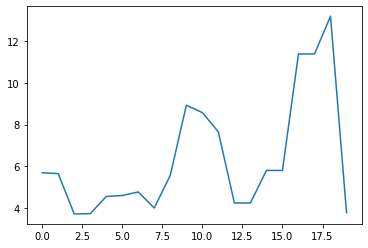

In [1109]:
plt.plot(ALL_TOP_CLASS_LOSS)

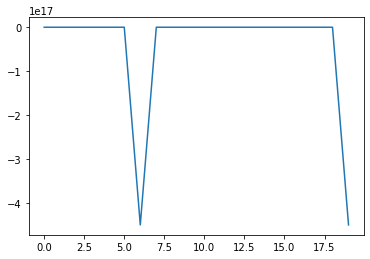

In [1110]:
plt.plot(ALL_TOP_HALF_LOSS)

In [1111]:
class_rmse = []
class_loss = []
for rma_class in best_architectures:
    class_rmse.append(rma_class.rmse)
    class_loss.append(rma_class.loss)

In [1112]:
best_rma_class = best_architectures[np.argmin(class_loss)]

In [1113]:
best_rma_class.rmse

3.484611016626092

In [1114]:
best_rma_class.loss

3.783189336689762

In [1115]:
BEST_RMA_CLASS.rmse

14.118240240268605

In [1116]:
BEST_RMA_CLASS.loss

14.143521657703486

In [1117]:
best_rma_class.model_architecture

array(['mf_pow', 'mf_max_pool', 'mf_running_avg', 'mf_max_pool',
       'mf_linear_transform', 'mf_convolve', 'mf_convolve', 'mf_convolve',
       'mf_discrete_avg', 'cos', 'mf_pow', 'mf_convolve',
       'mf_running_avg'], dtype='<U19')

In [1118]:
best_rma_class.n_pixel_to_process

4

In [1119]:
[best_rma_class.get_prediction_from_architecture(x_train[i]) for i in range(10)]

[7.496810845232214,
 3.7091799945899635,
 6.998095034913838,
 5.1439968019871305,
 7.896451040672617,
 6.747838030910179,
 1.8579000956357976,
 7.053131651136871,
 6.683477742656875,
 4.364079004002795]

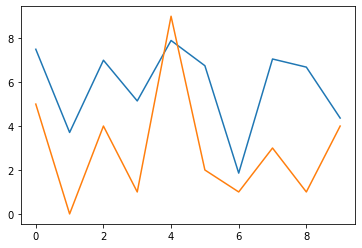

In [1120]:
# predictions
plt.plot([best_rma_class.get_prediction_from_architecture(x_train[i]) for i in range(10)])
plt.plot(y_train[:10])

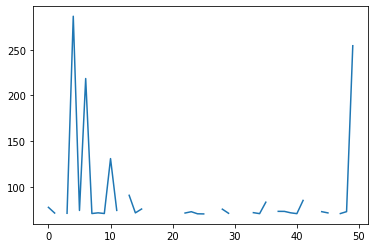

In [867]:
plt.plot(np.log([np.mean(FINAL_GENERATION_LOSS[i]) for i in range(len(FINAL_GENERATION_LOSS))]))

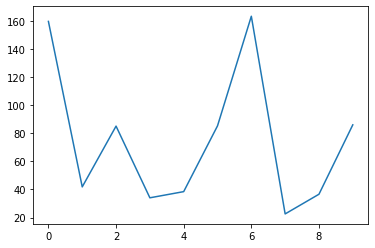

In [573]:
plt.plot(np.log([np.mean(FINAL_GENERATION_RMSE[i]) for i in range(len(FINAL_MODEL_RMSE))]))

In [166]:
np.log(custom_math_functions.mf_avg(test_array))

array([ 5.05199048,  5.45532112,  5.45532112,  5.45532112,  5.45532112,
        5.09783184,  4.60183128,  4.9102009 ,  7.14598447,  7.88845952,
       11.2976302 , 11.29315538, 11.44397188,  9.70135097,  9.73935949,
        9.7193243 ,  9.70279834, 10.04456747, 18.790751  , 25.90684342,
       25.90684983, 25.90608318, 16.04218732, 15.90971899, 13.57128126,
       13.57038253])

In [136]:
custom_math_functions.mf_pow(np.array([1,2,3]))

array([    1,   512, 19683])

In [134]:
custom_math_functions.mf_avg(np.log(custom_math_functions.mf_avg(test_array)))

array([ 8.35584226,  8.96001347,  9.54168752, 10.01712544, 11.21547463,
       12.83821231, 14.45999054, 16.06373717, 17.66633056, 19.26732632,
       20.85343227, 22.43885573])

In [52]:
custom_math_functions.weight

1

In [51]:
custom_math_functions.mf_avg([1,2,3,4,3,4,])

[1.0, 3.2, 2.0, 3.5, 3.0, 3.6666666666666665, 4.0, 3.5, 3.0, 4.0, 4.0, nan]

In [135]:
MODEL_ARCHITECTURES

['cos',
 'three_number_average',
 'three_number_average',
 'sin',
 'two_number_average',
 'cos',
 'log',
 'four_number_average',
 'log',
 'cos',
 'sin',
 'three_number_average',
 'sin',
 'five_number_average',
 'five_number_average',
 'sin',
 'sin',
 'five_number_average',
 'log',
 'four_number_average',
 'sin',
 'sin',
 'four_number_average']

In [70]:
final_prediction


[nan, nan]

In [50]:
x_train[0,...].shape

(784,)

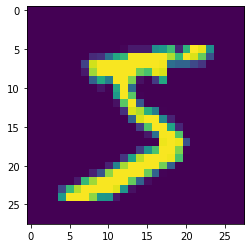

In [33]:
 plt.imshow(x_train[0,...].reshape(28,28,1))

array([100000])

# Define a NN model

In [ ]:
# activations
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)